In [1]:
import pandas as pd
import json
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.metrics import agreement

In [2]:
df = pd.read_csv('annotated-excerpts-with-themes.csv')
print(df.columns)
df = df.loc[df['1 = Relevant / 0 = Irrelevant'] == 1]
df = df.loc[df['1 = Reference'] != 1]

def str2set(x):
    if x == x:
        return set(x)
    return x

def clean(x):
    if type(x) != str:
        return x
    
    x_split = [i for i in x.split(',') if not i.strip().startswith('not ')]
    
    clean_map = {
        'constitutions': 'constitution',
        'emotions': 'emotion',
        'choices': 'choice',
        'arguments': 'argument',
        'campaigns': 'campaign',
        'accountable': 'accountability',
        'debates': 'debate',
        'elections': 'election',
        'deliberaton': 'deliberation',
        'discuourse': 'discourse',
        'dicourse': 'discourse',
        'freedom of speech': 'freedom',
        'harsassment': 'harassment',
        'preventing discrimination': 'discrimination',
        'quality-quantity tradeoff': 'quality vs. quantity tradeoff',
        'not hierarchical (MTL)': 'not hierarchical',
        'critical thinking': 'critical',
        'advancement': 'progress',
        'freedom': 'liberties',
        'civic education': 'education',
        'equal participation': 'equal contribution',
        'not user satisfaction': 'not satisfaction',
        'public reasoning': 'reasoning',
        'reduce need for expertise': 'reduce barriers',
        'political parties': 'political party',
        'protests': 'protest',
    } 
    return [i.strip() if i.strip() not in clean_map else clean_map[i.strip()] for i in x_split]

for col in ['AS Explicit Theme', 'AS Implicit Theme', 'Values',
       'VG Explicit Theme', 'VG Implicit Theme', 'Values.1']:
    df[col] = df[col].apply(clean).apply(str2set)

Index(['Corpus ID', 'Title', 'Excerpt', '1 = Relevant / 0 = Irrelevant',
       '1 = Reference', 'AS Explicit Theme', 'AS Implicit Theme', 'Values',
       'VG Explicit Theme', 'VG Implicit Theme', 'Values.1', 'Unnamed: 11',
       'democratization cause', 'democratization method(ology)',
       'democratization target', 'democratization goal/result'],
      dtype='object')


In [3]:
def sets2set(x):
    x = x.dropna()
    if len(x) > 0:
        return set.union(*x)
    return set()

as_agg_df = df.groupby('Corpus ID').agg(explicit=('AS Explicit Theme', sets2set), \
                                  implicit=('AS Implicit Theme', sets2set), \
                                  values=('Values', sets2set)
                                 )
vg_agg_df = df.groupby('Corpus ID').agg(explicit=('VG Explicit Theme', sets2set), \
                                  implicit=('VG Implicit Theme', sets2set), \
                                  values=('Values.1', sets2set)
                                 )

In [44]:
def masi_distance(label1, label2):
    len_intersection = len(label1.intersection(label2))
    len_union = len(label1.union(label2))

    if len_union == 0:
        return 0
    
    len_label1 = len(label1)
    len_label2 = len(label2)
    if len_label1 == len_label2 and len_label1 == len_intersection:
        m = 1
    elif len_intersection == min(len_label1, len_label2):
        m = 0.67
    elif len_intersection > 0:
        m = 0.33
    else:
        m = 0

    return 1 - len_intersection / len_union * m

def jaccard_distance(label1, label2):
    if len(label1.union(label2)) == 0:
        return 0
    return (len(label1.union(label2)) - len(label1.intersection(label2))) / len(label1.union(label2))

for col in ['explicit', 'implicit', 'values']:
    as_annot = list(zip(len(as_agg_df[col]) * ['as'], list(as_agg_df[col].index), list(as_agg_df[col].values)))
    vg_annot = list(zip(len(vg_agg_df[col]) * ['vg'], list(vg_agg_df[col].index), list(vg_agg_df[col].values)))
    all_annot = as_annot + vg_annot

    data = []
    for annot in all_annot:
        data.append((annot[0], annot[1], frozenset(annot[2])))

    jaccard_task = nltk.AnnotationTask(distance=jaccard_distance)
    masi_task = nltk.AnnotationTask(distance=masi_distance)
    tasks = [jaccard_task, masi_task]
    for task in tasks:
        task.load_array(data)
        print("Statistics for dataset using {}".format(task.distance))
        # print("C: {}\nI: {}\nK: {}".format(task.C, task.I, task.K))
        print("Pi: {}".format(task.pi()))
        print("Kappa: {}".format(task.kappa()))
        print("Multi-Kappa: {}".format(task.multi_kappa()))
        print("Alpha: {}".format(task.alpha()))
        print()

Statistics for dataset using <function jaccard_distance at 0x7f8ea2a5b820>
Pi: 0.9728690920994706
Kappa: 0.9728692452265788
Multi-Kappa: 0.9728692452265788
Alpha: 0.9720038884702775

Statistics for dataset using <function masi_distance at 0x7f8ea2a5baf0>
Pi: 0.9714554290036009
Kappa: 0.9714555901094374
Multi-Kappa: 0.9714555901094374
Alpha: 0.970867114006656

Statistics for dataset using <function jaccard_distance at 0x7f8ea2a5b820>
Pi: 0.8873873316930229
Kappa: 0.8874109968354431
Multi-Kappa: 0.8874109968354431
Alpha: 0.8873927948219744

Statistics for dataset using <function masi_distance at 0x7f8ea2a5baf0>
Pi: 0.8873873316930229
Kappa: 0.8874109968354431
Multi-Kappa: 0.8874109968354431
Alpha: 0.8874277355097386

Statistics for dataset using <function jaccard_distance at 0x7f8ea2a5b820>
Pi: 0.31895863586548545
Kappa: 0.34944502500821656
Multi-Kappa: 0.34944502500821656
Alpha: 0.3170697907680411

Statistics for dataset using <function masi_distance at 0x7f8ea2a5baf0>
Pi: 0.29485722970

In [5]:
comb_df = pd.concat([as_agg_df, vg_agg_df]).groupby('Corpus ID').agg({'explicit': lambda x: set.union(*x), \
                                                            'implicit': lambda x: set.union(*x), \
                                                            'values': lambda x: set.union(*x)})
print(np.mean([len(x) + len(y) for x, y in zip(comb_df['explicit'], comb_df['implicit'])]))
print(np.mean([len(x) for x in comb_df['values']]))

1.1600790513833992
1.0355731225296443


In [6]:
agg_df = pd.concat([as_agg_df, vg_agg_df]).groupby('Corpus ID').agg({'explicit': lambda x: set.union(*x), \
                                                            'implicit': lambda x: set.union(*x), \
                                                            'values': lambda x: set.union(*x)})
all_values = sorted(list(set.union(*agg_df['values'])))
print(',\n'.join(repr([v for v in all_values]).split(', ')))

['AI',
'WEIRD',
'acceleration',
'access',
'accountability',
'affordable',
'anti-power',
'anxiety',
'argument',
'available',
'benefit',
'bill writing',
'broader audience',
'campaign',
'caution',
'censorship',
'choice',
'citizenship',
'civility',
'cohesion',
'competence',
'complexity',
'conflict',
'consensus',
'consistency',
'constitution',
'cooperation',
'correctness',
'critical',
'data',
'debate',
'decentralization',
'deliberation',
'dialogue',
'direct democracy',
'disagreement',
'discourse',
'discrimination',
'discussion',
'disinformation',
'distributed',
'diversity',
'ease of use',
'education',
'efficiency',
'election',
'emotion',
'engagement',
'environment',
'equal contribution',
'equal representation',
'equality',
'evolving',
'fairness',
'fast',
'freedom',
'generalizability',
'governance',
'happiness',
'harassment',
'hierarchy of representatives',
'inclusion',
'information',
'informed',
'integrity',
'interaction',
'justice',
'lack of prejudice',
'liberties',
'literacy',
'low-resour

In [7]:
values = set([
    'argument',
    'access',
    'accountability',
    'affordable',
    'anti-power',
    'available',
    'benefit',
    'caution',
    'choice',
    'civility',
    'cohesion',
    'competence',
    'conflict',
    'consensus',
    'consistency',
    'cooperation',
    'correctness',
    'critical',
    'debate',
    'decentralization',
    'deliberation',
    'dialogue',
    'direct democracy',
    'disagreement',
    'discussion',
    'distributed',
    'diversity',
    'ease of use',
    'education',
    'efficiency',
    'engagement',
    'equal contribution',
    'equal representation',
    'equality',
    'evolving',
    'fairness',
    'fast',
    'generalizability',
    'happiness',
    'hierarchy of representatives',
    'inclusion',
    'information',
    'informed',
    'integrity',
    'interaction',
    'justice',
    'lack of prejudice',
    'liberties',
    'literacy',
    'majority',
    'moderation',
    'multilingual',
    'not armed attacks',
    'not authoritarian',
    'not autocratic',
    'not communism',
    'not dictatorship',
    'not fascist',
    'not gatekeeping',
    'not hierarchical',
    'not oligarchic',
    'not populism',
    'not radical Islam',
    'not satisfaction',
    'not socialism',
    'not terrorism',
    'open-source',
    'optimality',
    'participation',
    'power',
    'privacy',
    'proficiency',
    'progress',
    'protection',
    'quality',
    'random selection',
    'rational',
    'reasoning',
    'reduce barriers',
    'reflection',
    'replicability',
    'representation',
    'resource-efficient',
    'responsibility',
    'rights',
    'scalable',
    'social good',
    'sustainability',
    'transparency',
    'trust',
    'value'])

def get_values(x):
    return set([e for e in x if e in values])

In [8]:
split = 3

terms = [x for x in list(values) if not x.startswith('not ')]
print(len(terms))
max_len = len(terms) // split + 1

df_data = {i: terms[i * max_len:(i + 1) * max_len] for i in range(split)}

for key in df_data:
    if len(df_data[key]) < max_len:
        df_data[key] += (max_len - len(df_data[key])) * ['']

with pd.option_context("max_colwidth", 1000):
    print(pd.DataFrame(df_data).to_latex(index=False))

77
\begin{tabular}{lll}
\toprule
0 & 1 & 2 \\
\midrule
scalable & progress & access \\
disagreement & competence & ease of use \\
random selection & caution & reduce barriers \\
inclusion & moderation & affordable \\
correctness & lack of prejudice & debate \\
decentralization & consensus & accountability \\
informed & social good & sustainability \\
fairness & equality & representation \\
integrity & open-source & equal representation \\
privacy & argument & happiness \\
resource-efficient & consistency & dialogue \\
education & replicability & optimality \\
engagement & transparency & hierarchy of representatives \\
generalizability & diversity & interaction \\
deliberation & fast & benefit \\
reasoning & justice & cohesion \\
liberties & trust & conflict \\
critical & rational & equal contribution \\
rights & literacy & majority \\
power & distributed & discussion \\
civility & multilingual & quality \\
protection & efficiency & responsibility \\
information & cooperation & value \\

In [9]:
def contains(x, theme_set):
    for e in x:
        if e in theme_set:
            return True
    return False

In [10]:
filtered_agg_df = agg_df['values'][(~agg_df['explicit'].apply(lambda x: contains(x, []))) \
                                       & (~agg_df['implicit'].apply(lambda x: contains(x, [])))]
uniq_concepts = set(filtered_agg_df.apply(list).sum())
print(len(uniq_concepts))
print()

split = 3

terms = [x for x in list(uniq_concepts) if not x.startswith('not ')]
max_len = len(terms) // split + 1

df_data = {i: terms[i * max_len:(i + 1) * max_len] for i in range(split)}

for key in df_data:
    if len(df_data[key]) < max_len:
        df_data[key] += (max_len - len(df_data[key])) * ['']

with pd.option_context("max_colwidth", 1000):
    print(pd.DataFrame(df_data).to_latex(index=False))

110

\begin{tabular}{lll}
\toprule
0 & 1 & 2 \\
\midrule
scalable & evolving & proficiency \\
political party & anti-power & data \\
disagreement & progress & public opinion \\
random selection & competence & access \\
inclusion & caution & ease of use \\
correctness & moderation & reduce barriers \\
AI & discrimination & affordable \\
decentralization & lack of prejudice & bill writing \\
informed & consensus & debate \\
fairness & social good & accountability \\
freedom & environment & sustainability \\
citizenship & campaign & news \\
integrity & equality & representation \\
privacy & replicability & media \\
discourse & consistency & misinformation \\
election & open-source & equal representation \\
resource-efficient & transparency & happiness \\
education & argument & dialogue \\
engagement & diversity & hierarchy of representatives \\
censorship & low-resource & emotion \\
generalizability & fast & interaction \\
deliberation & harassment & translation \\
questioning & justice &

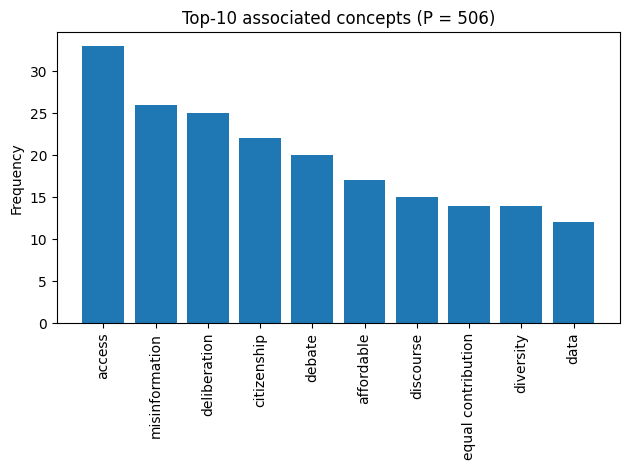

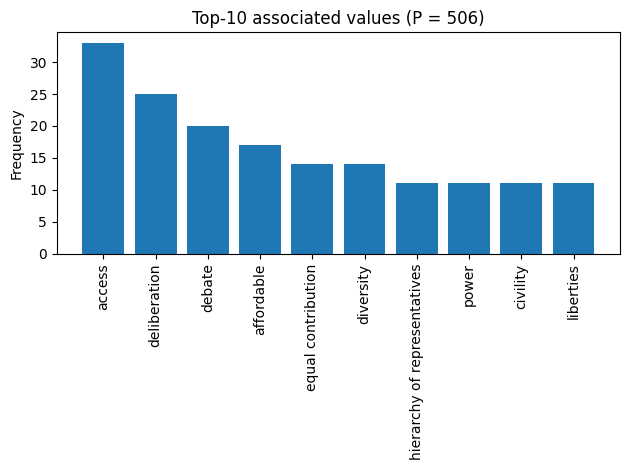

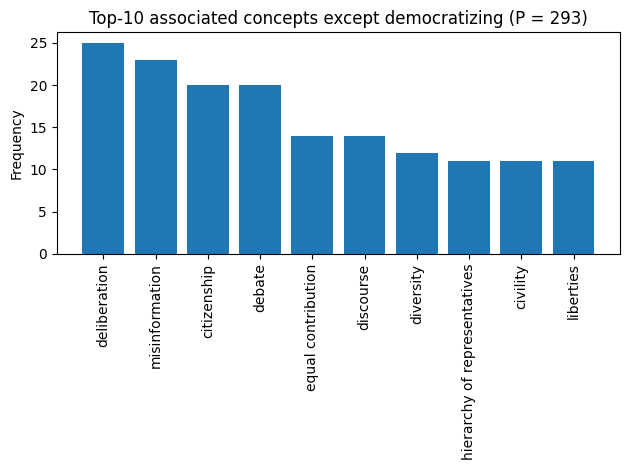

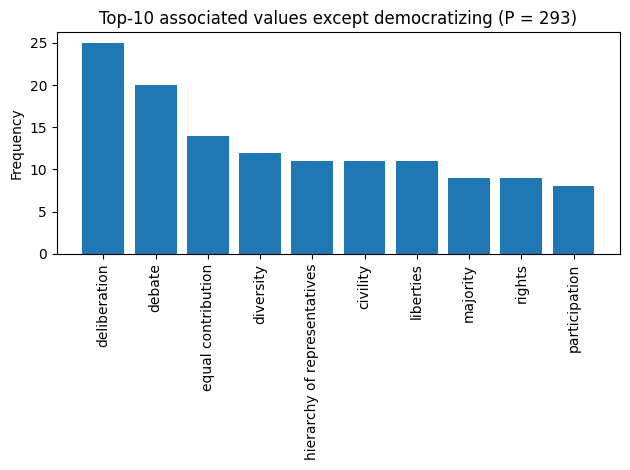

In [11]:
for exclude_explicit, exclude_implicit, exclude_desc in [
    ([], [], ''),
    (set(['democratizing']), set(), 'democratizing')
]:
    filtered_agg_df = agg_df['values'][(~agg_df['explicit'].apply(lambda x: contains(x, exclude_explicit))) \
                                       & (~agg_df['implicit'].apply(lambda x: contains(x, exclude_implicit)))]

    freqs = Counter(filtered_agg_df.apply(list).sum())
    
    topk = freqs.most_common(10)
    
    plt.bar(list(zip(*topk))[0], list(zip(*topk))[1])
    plt.xticks(rotation=90)
    plt.ylabel('Frequency')
    
    if exclude_desc != '':
        exclude_desc = 'except ' + exclude_desc + ' '
    plt.title('Top-10 associated concepts {}(P = {})'.format(exclude_desc, len(filtered_agg_df)))
    plt.tight_layout()
    plt.savefig('thematic-analysis-plots/' + '_'.join([x.lower() for x in 'All associated concepts {}'.format(exclude_desc).split()]) + '.pdf')
    plt.show()
    
    freqs = Counter(filtered_agg_df.apply(get_values).apply(list).sum())
    
    topk = freqs.most_common(10)
    
    plt.bar(list(zip(*topk))[0], list(zip(*topk))[1])
    plt.xticks(rotation=90)
    plt.ylabel('Frequency')
    
    plt.title('Top-10 associated values {}(P = {})'.format(exclude_desc, len(filtered_agg_df)))
    plt.tight_layout()
    plt.savefig('thematic-analysis-plots/' + '_'.join([x.lower() for x in 'All associated values {}'.format(exclude_desc).split()]) + '.pdf')
    plt.show()

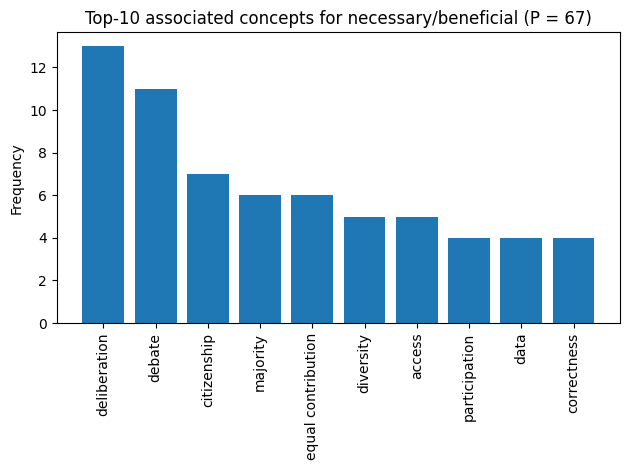

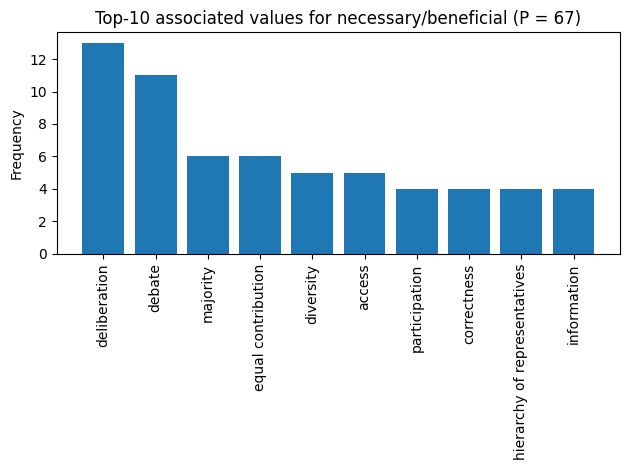

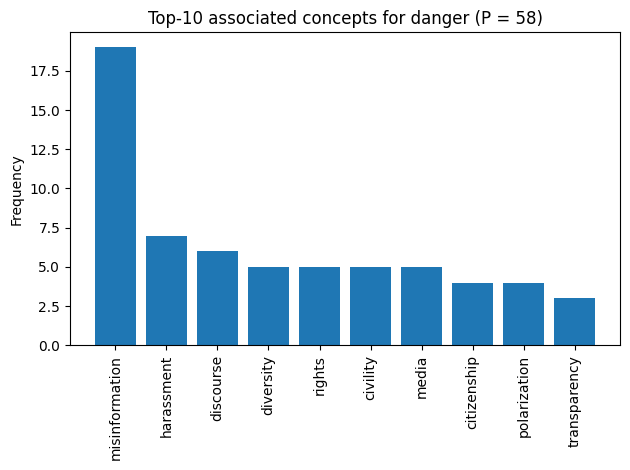

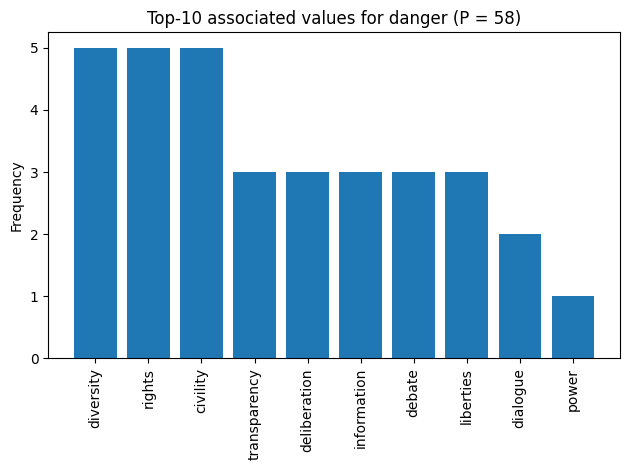

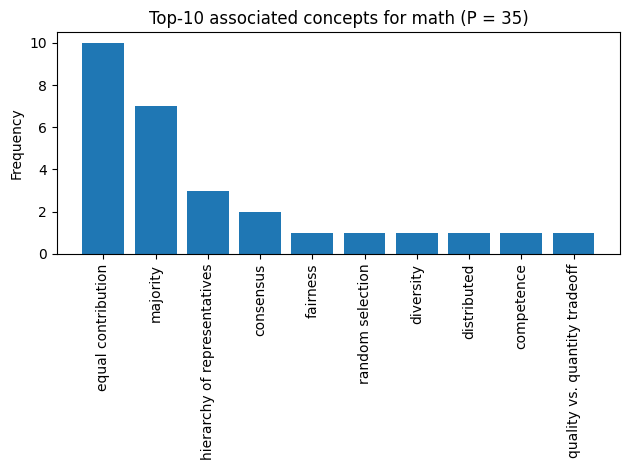

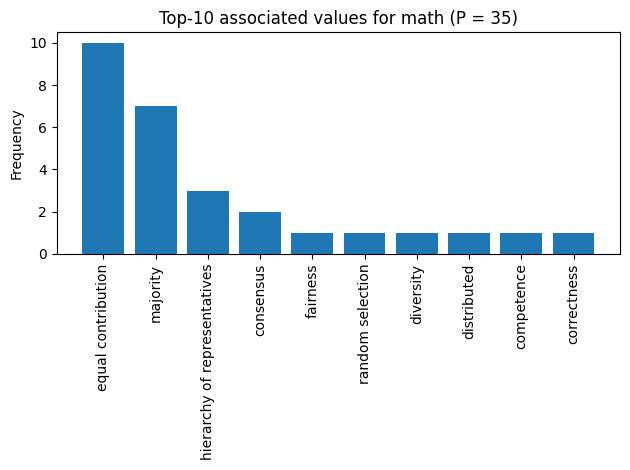

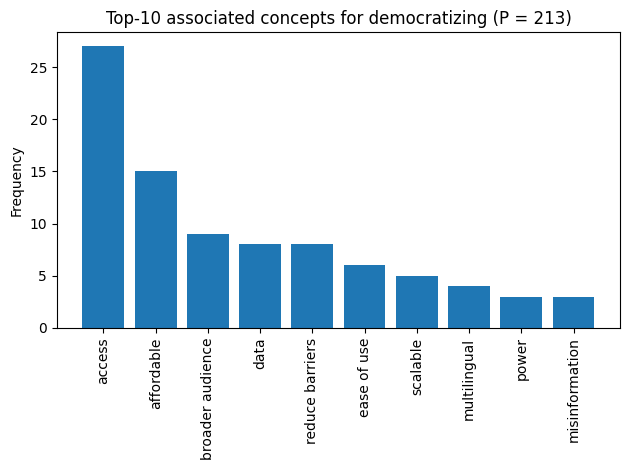

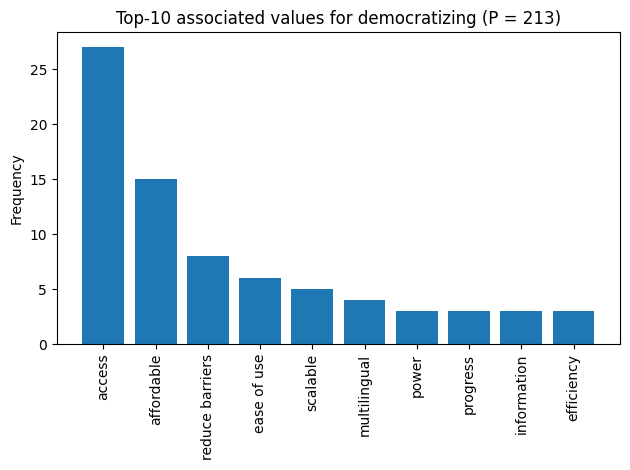

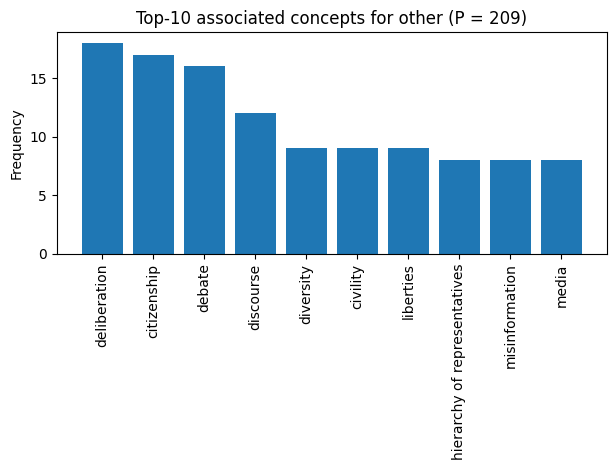

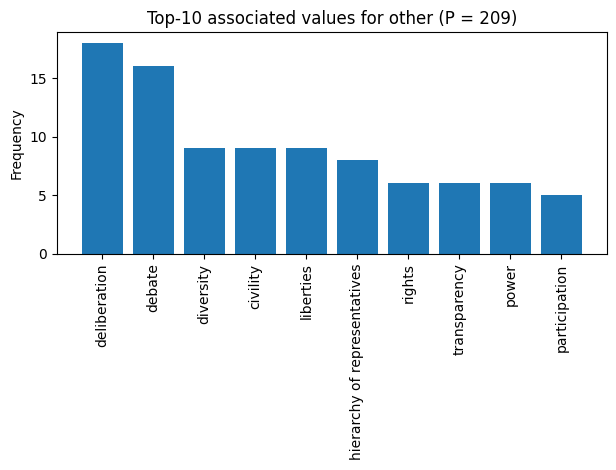

In [12]:
for theme in ['necessary/beneficial', 'danger', 'math', 'democratizing', 'other']:
    include_explicit = set([theme])
    include_implicit = set([theme])
    include_desc = 'for ' + theme + ' '

    filtered_agg_df = agg_df['values'][(agg_df['explicit'].apply(lambda x: contains(x, include_explicit))) |
                                       (agg_df['implicit'].apply(lambda x: contains(x, include_implicit)))]
    
    freqs = Counter(filtered_agg_df.apply(list).sum())
    
    topk = freqs.most_common(10)
    
    plt.bar(list(zip(*topk))[0], list(zip(*topk))[1])
    plt.xticks(rotation=90)
    plt.ylabel('Frequency')
    
    plt.title('Top-10 associated concepts {}(P = {})'.format(include_desc, len(filtered_agg_df)))
    plt.tight_layout()
    plt.savefig('thematic-analysis-plots/' + '_'.join([x.lower() for x in 'All associated concepts {}'.format(include_desc).split()]).replace('/', '_') + '.pdf')
    plt.show()
    
    freqs = Counter(filtered_agg_df.apply(get_values).apply(list).sum())
    
    topk = freqs.most_common(10)
    
    plt.bar(list(zip(*topk))[0], list(zip(*topk))[1])
    plt.xticks(rotation=90)
    plt.ylabel('Frequency')
    
    plt.title('Top-10 associated values {}(P = {})'.format(include_desc, len(filtered_agg_df)))
    plt.tight_layout()
    plt.savefig('thematic-analysis-plots/' + '_'.join([x.lower() for x in 'All associated values {}'.format(include_desc).split()]).replace('/', '_') + '.pdf')
    plt.show()

## Democratizing

125


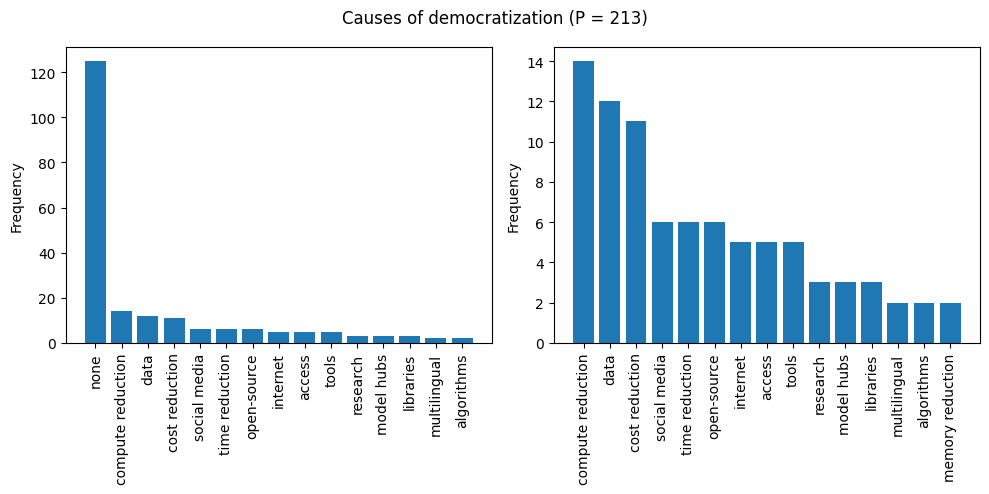

14


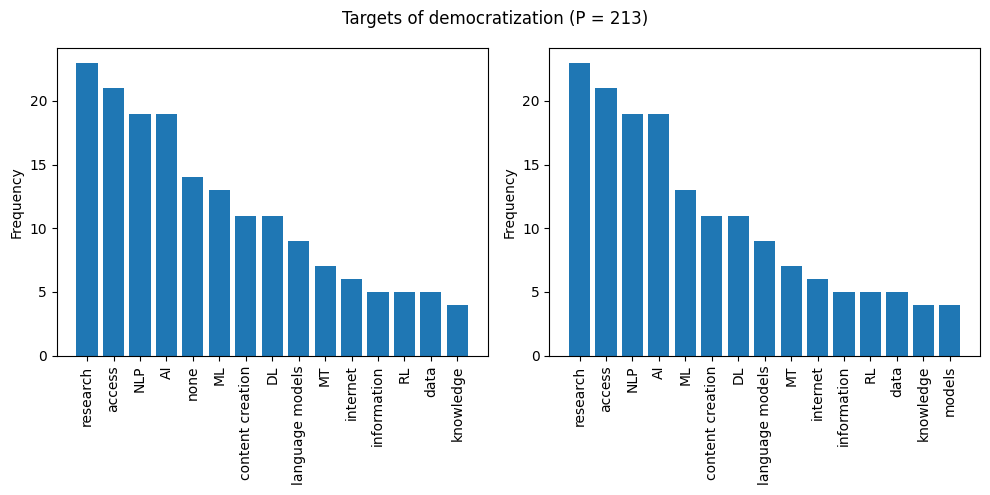

159


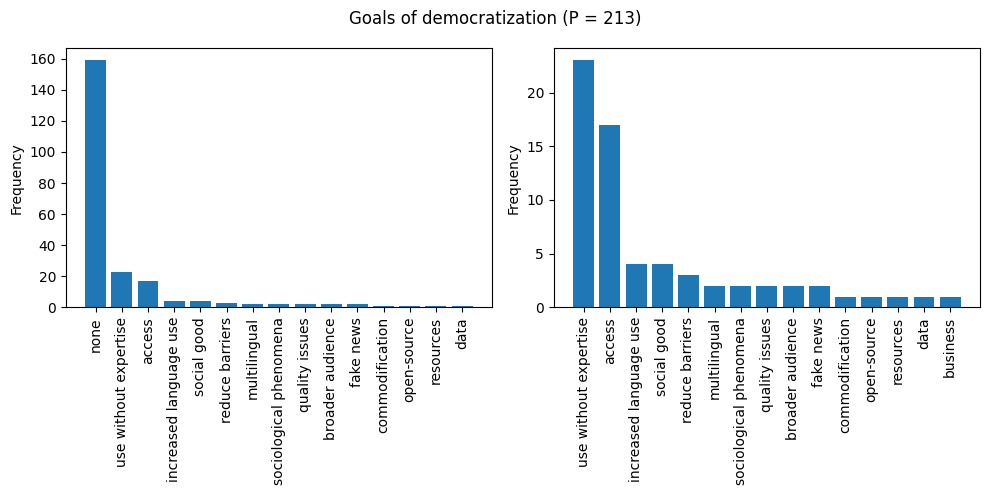

In [13]:
def str2set_withnan(x):
    if x == x:
        return set(x)
    return set(['none'])

uniq_vals = set()

for col, title in [('democratization cause', 'Causes of democratization'), \
                        # ('democratization method(ology)', 'Democratization methodologies'), \
                        ('democratization target', 'Targets of democratization'), \
                        ('democratization goal/result', 'Goals of democratization')]:
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    for idx, conv_func in enumerate([str2set_withnan, str2set]):
        
        dem_df = pd.read_csv('annotated-excerpts-with-themes.csv')
        dem_df = dem_df.loc[dem_df['1 = Relevant / 0 = Irrelevant'] == 1]
        dem_df = dem_df.loc[dem_df['1 = Reference'] != 1]
        dem_df = dem_df.loc[(dem_df['AS Explicit Theme'] == 'democratizing') | (dem_df['VG Explicit Theme'] == 'democratizing')]

        dem_df[col] = dem_df[col].apply(clean).apply(conv_func)
    
        dem_agg_df = dem_df.groupby('Corpus ID').agg(target=(col, sets2set))
        
        freqs = Counter(dem_agg_df['target'].apply(list).sum())
        uniq_vals.update(list(freqs.keys()))

        if 'none' in freqs:
            print(freqs['none'])
    
        topk = freqs.most_common(15)

        axs[idx].bar(list(zip(*topk))[0], list(zip(*topk))[1])
        axs[idx].tick_params(axis='x', labelrotation=90)
        axs[idx].set_ylabel('Frequency')

    plt.suptitle('{} (P = {})'.format(title, len(dem_agg_df['target'])))
    plt.tight_layout()
    plt.savefig('thematic-analysis-plots/' + '_'.join([x.lower() for x in title.split()]) + '.pdf')
    plt.show()

In [14]:
uniq_vals

{'3D content creation',
 '3D model generation',
 '3D reconstruction',
 'AI',
 'AR filters',
 'ASR',
 'ASR technology',
 'DL',
 'Lesan',
 'LiDAR',
 'ML',
 'MT',
 'NLP',
 'NNs',
 'Python ecosystem',
 'RL',
 'Twitter',
 'access',
 'access without expertise',
 'accessibility',
 'accessible',
 'accuracy',
 'adoption',
 'advances',
 'algorithms',
 'analysis',
 'animation',
 'annotation',
 'applications',
 'asynchronous collaboration',
 'automation',
 'availability',
 'benchmarks',
 'books',
 'broader audience',
 'business',
 'cancel culture',
 'classification algorithms',
 'cobots',
 'code',
 'commodification',
 'communications',
 'compression',
 'compression algorithms',
 'computation',
 'compute',
 'compute reduction',
 'computers',
 'content creation',
 'content generation',
 'cost',
 'cost reduction',
 'culture',
 'cyberbullying',
 'data',
 'data collection',
 'data literacy',
 'data-efficiency',
 'decentralized learning',
 'democratization',
 'dermatology',
 'design',
 'dialects',
 'dia